In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from utils import loader

In [4]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

device: cpu


In [5]:
# model architecture
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.in_to_hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.in_to_out = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.in_to_hidden(combined)
        out = self.in_to_out(combined)
        out = self.softmax(out)
        return out, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [6]:
# dataset
names, labels = loader.load_data()
n_categories = len(labels)
n_categories

19

In [7]:
n_hidden = 128
model = RNN(loader.N_LETTERS, n_hidden, n_categories).to(device)

In [8]:
# Category from output
def category_from_output(output):
    catagory_idx = torch.argmax(output).item()
    return labels[catagory_idx]

In [99]:
# Loss and optimizer
learning_rate = 0.0000001
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [100]:
def train(name_tensor, label_tensor):
    hidden = model.init_hidden()
    for i in range(name_tensor.size()[0]):
        output, hidden = model(name_tensor[i], hidden)
    loss = criterion(output, label_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return output, loss.item()

In [101]:
# Training
n_iters = 100000
print_every = 5000
plot_every = 1000
current_loss = 0
all_losses = []
for iter in range(1, n_iters + 1):
    category, name, label_tensor, name_tensor = loader.random_training_example(names, labels)
    output, loss = train(name_tensor, label_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess = category_from_output(output)
        correct = '✅' if guess == category else f'❌ ({category})'
        print(f'{iter} {iter/n_iters*100:.2f}% ({name}) {loss:.4f} {name} / {guess} {correct}')

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5.00% (Cabral) 1.5157 Cabral / Portuguese ✅
10000 10.00% (Baidin) 2.3397 Baidin / Arabic ❌ (Russian)
15000 15.00% (Priimkov) 0.1785 Priimkov / Russian ✅
20000 20.00% (O'Brien) 0.6482 O'Brien / Irish ✅
25000 25.00% (yokeethasri) 0.0000 yokeethasri / Indian ✅
30000 30.00% (Kaiser) 2.2413 Kaiser / Arabic ❌ (Czech)
35000 35.00% (Trieu) 0.9660 Trieu / Vietnamese ✅
40000 40.00% (Cha) 1.2597 Cha / Chinese ❌ (Korean)
45000 45.00% (Pelaez) 1.5598 Pelaez / Spanish ✅
50000 50.00% (karthic) 0.0144 karthic / Indian ✅
55000 55.00% (Zilberschlag) 2.9031 Zilberschlag / Greek ❌ (German)
60000 60.00% (Ferguson) 0.6121 Ferguson / Scottish ✅
65000 65.00% (Laconi) 0.4109 Laconi / Italian ✅
70000 70.00% (Ghanem) 0.7694 Ghanem / Arabic ✅
75000 75.00% (Abatangelo) 0.5514 Abatangelo / Italian ✅
80000 80.00% (Wareing) 2.2063 Wareing / Italian ❌ (English)
85000 85.00% (Vincent) 1.3782 Vincent / French ✅
90000 90.00% (Chun) 1.1503 Chun / Korean ✅
95000 95.00% (Treasach) 2.1103 Treasach / French ❌ (Irish)
100

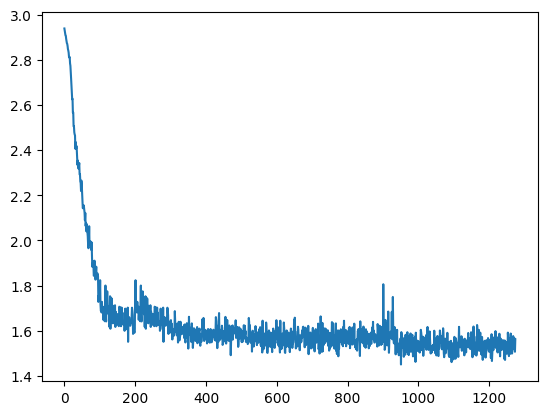

In [103]:
# Plotting the results
plt.figure()
plt.plot(losses)
plt.show()

In [104]:
# Prediction function
def predict(name):
    with torch.no_grad():
        name_tensor = loader.line_to_tensor(name)
        hidden = model.init_hidden()
        for i in range(name_tensor.size()[0]):
            output, hidden = model(name_tensor[i], hidden)  
        label = category_from_output(output)
        confidence = torch.exp(output).max().item()
        return label, confidence

In [105]:
# Evaluation accuracy
with torch.no_grad():
    n_correct = 0
    n_total = 0
    for category in labels:
        for name in names[category]:
            label, confidence = predict(name)
            n_total += 1
            if label == category:
                n_correct += 1
    print(f'accuracy: {n_correct/n_total:.2f}')

accuracy: 0.60


In [106]:
# saving the model and labels
save_path = '../model'
torch.save(model.state_dict(), f"{save_path}/model.pth")
np.save(f'{save_path}/labels.npy', labels)

In [109]:
# loading saved model
loaded_model = RNN(loader.N_LETTERS, n_hidden, n_categories).to(device)
loaded_model.load_state_dict(torch.load(f"{save_path}/model.pth"))
loaded_model.eval()

RNN(
  (in_to_hidden): Linear(in_features=185, out_features=128, bias=True)
  (in_to_out): Linear(in_features=185, out_features=19, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [114]:
# loading the labels
loaded_labels = np.load(f'{save_path}/labels.npy', allow_pickle=True).tolist()
loaded_labels

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Indian',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [115]:
# Prediction function
def predict(name):
    with torch.no_grad():
        name_tensor = loader.line_to_tensor(name)
        hidden = loaded_model.init_hidden()
        for i in range(name_tensor.size()[0]):
            output, hidden = loaded_model(name_tensor[i], hidden)  
        label = category_from_output(output)
        confidence = torch.exp(output).max().item()
        return label, confidence
    
# Evaluation accuracy
with torch.no_grad():
    n_correct = 0
    n_total = 0
    for category in loaded_labels:
        for name in names[category]:
            label, confidence = predict(name)
            n_total += 1
            if label == category:
                n_correct += 1
    print(f'accuracy: {n_correct/n_total:.2f}')
    
# Prediction
predict('Dovesky') # Russian

accuracy: 0.60


('Russian', 0.21167872846126556)